In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import pandas
import pickle
import numpy
import datetime
import math
import os
import scipy
import sklearn.cluster

Load agent data

In [153]:
def load_agent(directory, agent_ID):
    with open(directory + agent_ID + '.pkl', 'rb') as agent_file:
        agent_data = pickle.load(agent_file)
    return agent_data
def load_dict_agents_data(directory):
    result = {}
    all_agent_IDs = set([files[:-4] for files in os.listdir(directory) if files[0] != '.'])
    for ID in all_agent_IDs:
        agent_data = load_agent(directory, ID)
        result[ID] = agent_data
    return result
def get_dataframe_data(data_agents):
    stripped_dict = {}
    for agent in data_agents:
        stripped_dict[agent] = {}
        for key, val in data_agents[agent].items():
            if (isinstance(val, int) or isinstance(val, float) or isinstance(val, str)):
                stripped_dict[agent][key] = val
    return pandas.DataFrame.from_dict(stripped_dict, orient = 'index')
def sum_distributions(distributions, as_type = 'int'):
    total_distribution = pandas.Series()
    count = 0
    for dist in distributions:
        if isinstance(dist, pandas.DataFrame):
            continue
        if total_distribution.empty:
            count +=1
            total_distribution = dist
        else:
            count+=1
            total_distribution = total_distribution.radd(dist, level=None, fill_value=0, axis=0)
    if as_type == 'int':
        return total_distribution.astype(int)   
    elif as_type == 'float':
        return total_distribution.astype(float)
    else:
        print('unknown type, supported are int and float')
        return total_distribution
def sum_lists(lists, as_type = 'int'):
    length = len(lists[0])
    for item in lists:
        if len(item) != length:
            print('lists should be same length')
            return
    if as_type == 'int':
        summed_list = [0] * len(lists[0])
    elif as_type == 'float':
        summed_list = [0.0] * len(lists[0])
    else:
        print('unsupported as_type in sum_lists, should be int or float')
        return 
    for i in range(len(lists[0])):
        for l in lists:
            summed_list[i] += l[i]
    return summed_list
def get_mean_and_sd(lists):
    length = len(lists[0])
    for item in lists:
        if len(item) != length:
            print('lists should be same length')
            return
    bin_values = []
    for i in range(len(lists[0])):
        bin_values.append([])
        for l in lists:
            bin_values[i].append(l[i])
    means = [numpy.mean(l) for l in bin_values]
    sds = [numpy.std(l) for l in bin_values]
    return means, sds
def get_error(expected_pattern, simulated_pattern):
        ''' This method calculates the error between two activity patterns.
            Each bin in the expected activity pattern is compared to the
            simulated activity pattern and the error is calculated. The method
            returns the mean error over all the bins in the patterns. Two types
            of error calculation are supported: the Mean Abolute Error (MEA)
            and the relative MAE. The MAE of a bin is defined as the difference
            between the simulated and real value.  The relative error of a bin
            is defined as the difference between the simulated and real value
            the bin divided by the maximum error of this bin. The maximum error
            is the maximum distance of the real bin to either 0 or 1. The error
            is then (in both cases) multiplied by 100 to get the error range
            between 0 and 100.

        Args:
            expected_pattern (List[float]): The expected activity pattern.
            simulated_pattern (List[float]): The simulated activity pattern.

        Kwargs:
            method (str): Method of validation. 'MAE' for Mean Absolute Error
                or 'relMAE' for relative Mean Absolute Error. Default 'relMAE'.

        Returns:
            (float): The error between the expected and the simulated pattern.
        '''

        nr_bins = len(expected_pattern)
        error = 0
        for i in range(nr_bins):
            expected = expected_pattern[i]
            simulated = simulated_pattern[i]
            difference = numpy.abs(simulated - expected)
            max_distance = max(1 - expected, expected)
            error += 100 * ( difference / max_distance)
           

        return error / nr_bins 

def plot_mean_dist(agents, dc_dists_phev, cluster, xmax = None):
    dists = []
    max_size = 2880
    for ID in agents:
        dist = list(dc_dists_phev[ID])
        while (len(dist) < max_size):
            dist.append(0.0)
        s = sum(dist[:max_size])
        dist = [val / s for val in dist[:max_size]]
        dists.append(dist)
    means, sds = get_mean_and_sd(dists)
    dc_dist = sum_lists(dists, as_type = 'float')
    s = sum(dc_dist)
    dc_dist = [val / s for val in dc_dist]
    seaborn.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(12, 6))
    xvals = [(1.0 * i *20/60/24) for i in range(max_size)]
    plt.plot(xvals, dc_dist)
    plt.title('cluster %d (%d agents)\n%.5f sd' %(c, len(agents), numpy.mean(sds)))
    plt.xlabel('Disconnection in days')
    if xmax != None:
        plt.xlim(0, xmax)
    plt.show()
    return dc_dist

def plot_dist(ID, dc_dists_phev, xmax = None, title = ' '):
    max_size = 2880
    dist = list(dc_dists_phev[ID])
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    seaborn.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(12, 6))
    xvals = [(1.0 * i *20/60/24) for i in range(max_size)]
    plt.plot(xvals, dist)
    plt.title(title)
    plt.xlabel('Disconnection in days')
    if xmax != None:
        plt.xlim(0, xmax)
    plt.show()
    
def simple_plot_mult_dist(xvals, yvals, yvals_labels, title = " ", xmin = 0, xmax = -1, ymin = None, colors = None,
                         xlab = ' '):
    seaborn.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(16, 8))
    labels = []
    if colors == None:
        colors = [None]*len(yvals)
    for i, yval in enumerate(yvals):
        lab, = plt.plot(xvals, yval, label = yvals_labels[i], linewidth=3, color = colors[i])
        labels.append(lab)
    if xmax > 0:
        plt.xlim(xmin, xmax)
    if ymin != None:
        plt.ylim(ymin,)
    plt.legend(handles=labels)
    plt.xlabel(xlab)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.show()
        
    

In [3]:
% time data_agents = load_dict_agents_data('data/agent_database/all_non_changing_agents/')
data_agents_df = get_dataframe_data(data_agents)

CPU times: user 44.6 s, sys: 1.03 s, total: 45.6 s
Wall time: 45.6 s


# PHEV

## Disconnection

Get all disconnection distributions of phev agents

In [4]:
dc_dists_phev = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] == 'phev':
        dc_dists_phev[ID] = sum_distributions(data_agents[ID]['disconnection_duration_dists'])


In [6]:
max_size = 2880
dc_dists_phev_same_length = {}
for ID in dc_dists_phev:
    dist = list(dc_dists_phev[ID])
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    dc_dists_phev_same_length[ID] = dist

Cluster phevs disconnection

In [142]:
col_names = ['%.2f' %(i *20/60*24) for i in range(max_size)]
clustering_data = []
agent_IDs = []
for ID in dc_dists_phev:
    dist = list(dc_dists_phev[ID])
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    clustering_data.append(dist)
    agent_IDs.append(ID)
clustering_data = pandas.DataFrame(clustering_data, columns = col_names, index = agent_IDs)

In [143]:
matrix = clustering_data.as_matrix()
birch = sklearn.cluster.Birch(
    threshold = 0.1,
    n_clusters = 6,
    branching_factor = 50)
birch.fit(matrix)
results = pandas.DataFrame(data = birch.labels_,
    columns=['cluster'], index = clustering_data.index)
# clusters = {tuple(cluster[1].index) for cluster in results.groupby('cluster')}

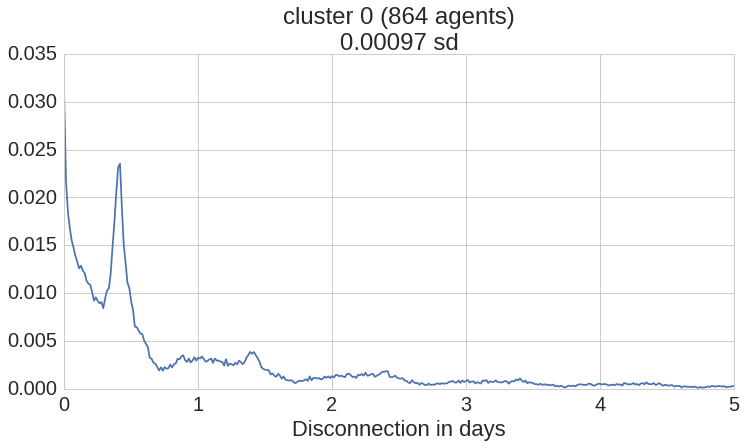

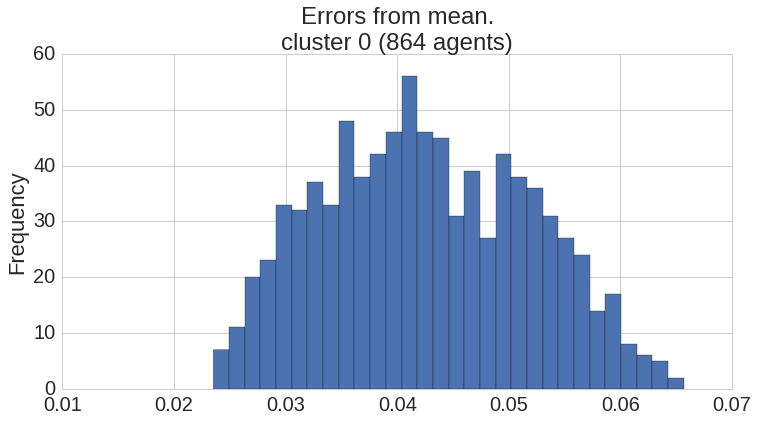

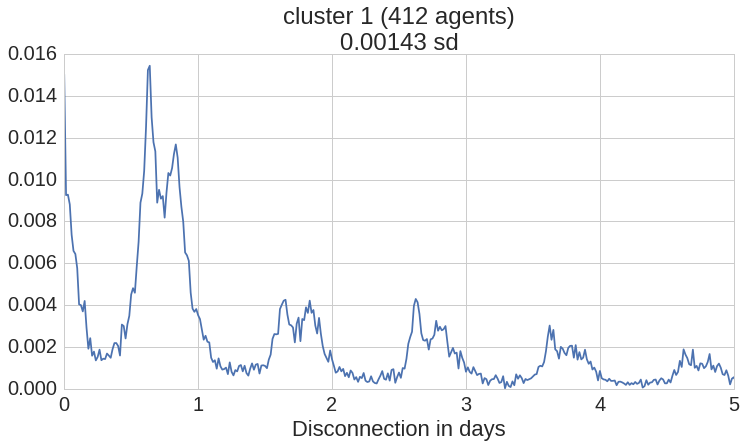

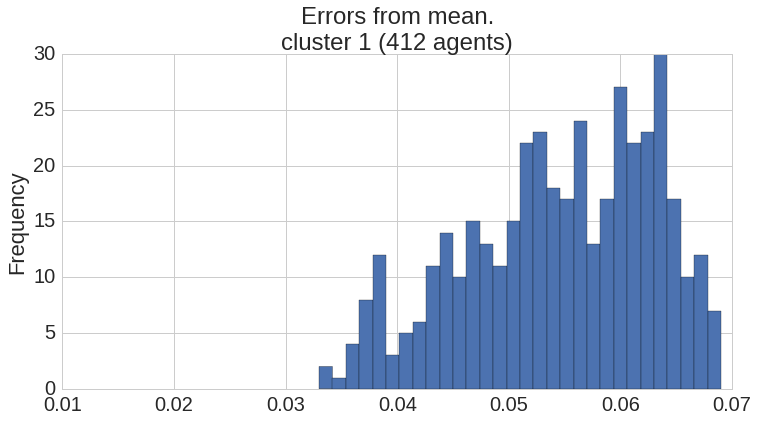

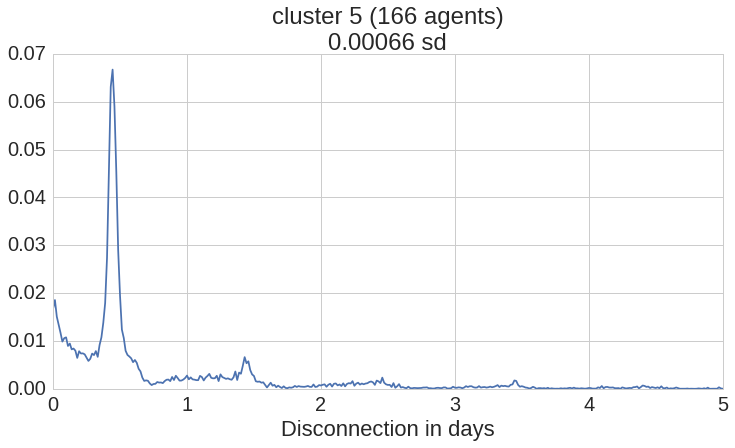

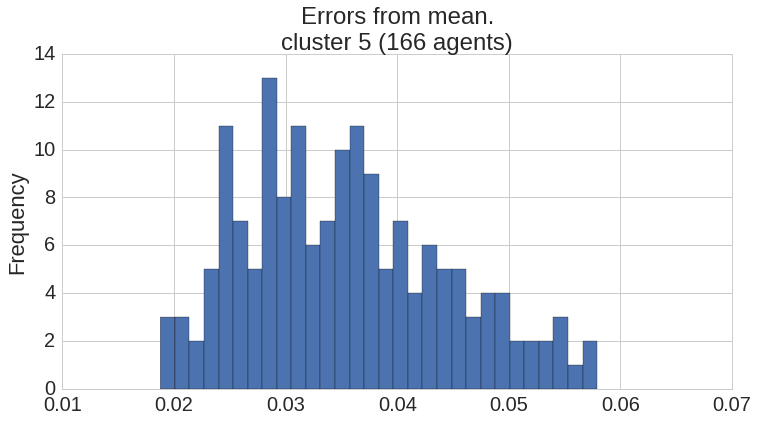

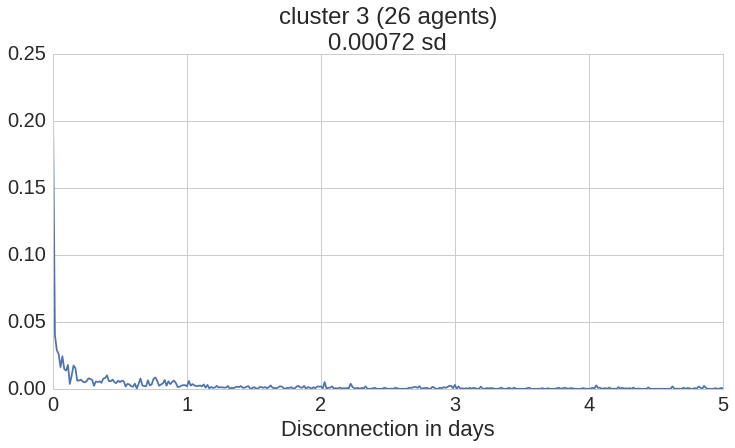

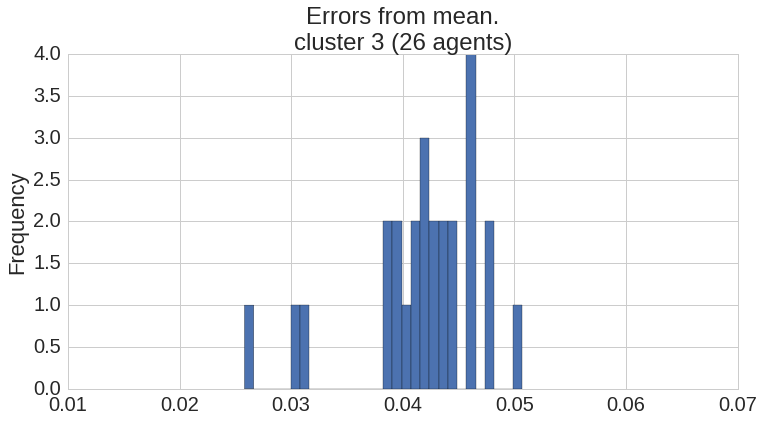

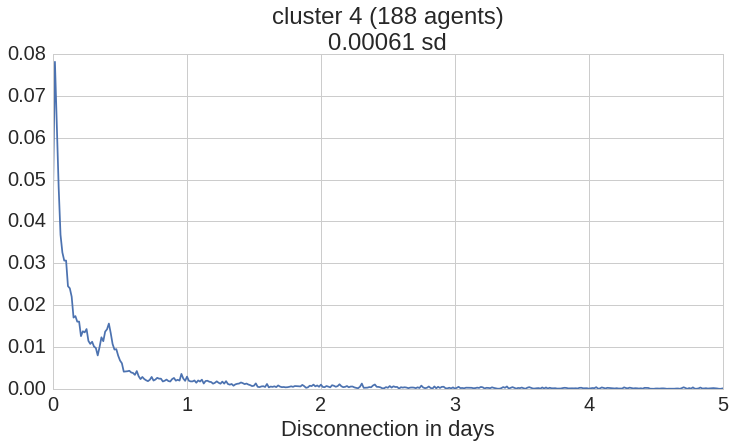

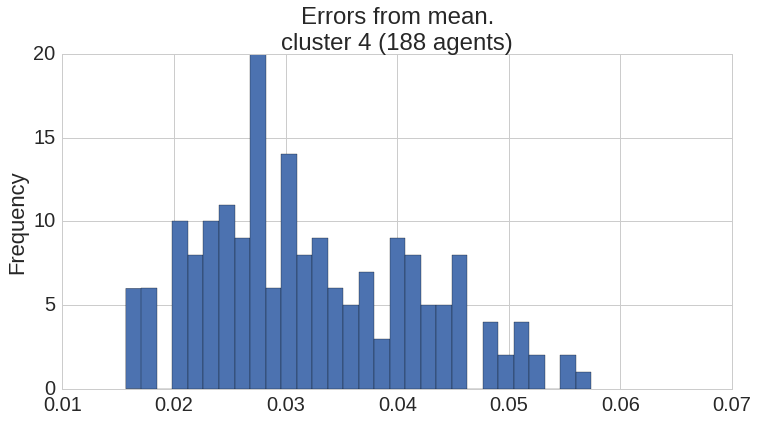

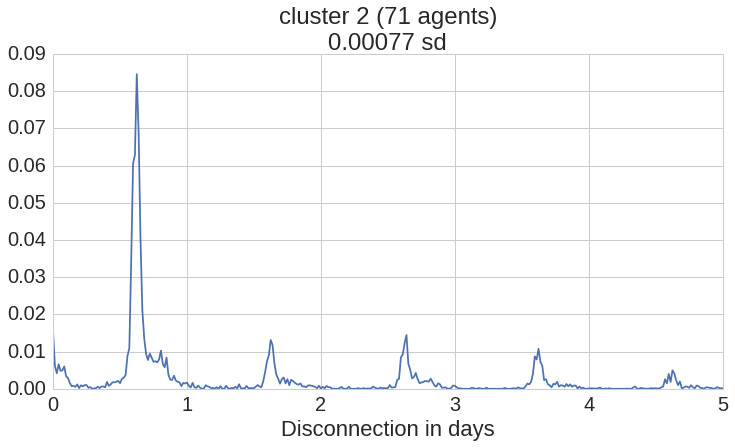

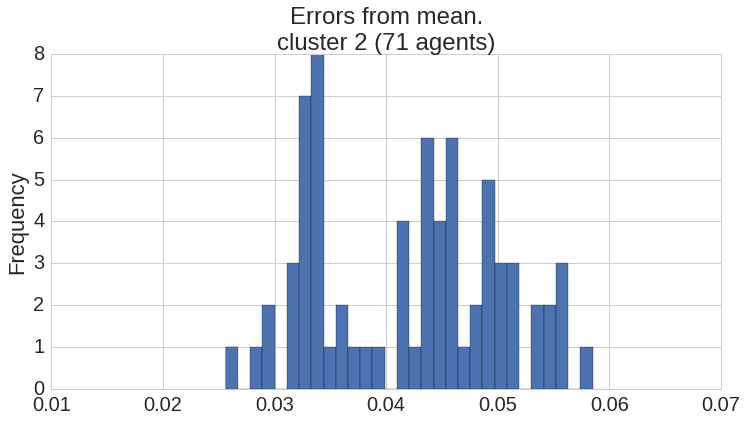

In [144]:
clusters = results['cluster'].unique()
clusters_errors = {}
for c in clusters:
    agents = list(results.loc[results['cluster'] == c].index)
    mean_dist = plot_mean_dist(agents, dc_dists_phev, c, xmax = 5)
    cluster_errors = {ID: get_error(mean_dist[:max_size], dc_dists_phev_same_length[ID]) for ID in agents}
    errors_from_mean = list(cluster_errors.values())
    clusters_errors.update(cluster_errors)
    seaborn.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(12, 6))
    plt.hist(errors_from_mean, bins = 30)
    plt.title('Errors from mean.\ncluster %s (%d agents)' %(c, len(agents)))
    plt.ylabel('Frequency')
    plt.xlim(0.01,0.07)
    plt.show()



Compare with overall phev

In [100]:
directory = 'data/simulation_pkls/'
with open(directory + 'disconnection_distribution_phev.pkl', 'rb') as f:
    disconnection_distribution_phev = pickle.load(f)
all_agents_normed_dc = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'phev':
        continue
    dist = list(sum_distributions(data_agents[ID]['disconnection_duration_dists']))
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_dc[ID] = dist
agents = list(all_agents_normed_dc.keys())
errors_from_mean_overall = [get_error(disconnection_distribution_phev[:max_size], all_agents_normed_dc[ID]) 
                            for ID in agents]

In [12]:
compare_errors = {ID: {'overall_error': get_error(disconnection_distribution_phev[:max_size], all_agents_normed_dc[ID]), 
      'cluster_error': clusters_errors[ID]} for ID in agents}

In [13]:
diff_errors = []
for ID in compare_errors:
    diff_errors.append(compare_errors[ID]['overall_error'] - compare_errors[ID]['cluster_error'])

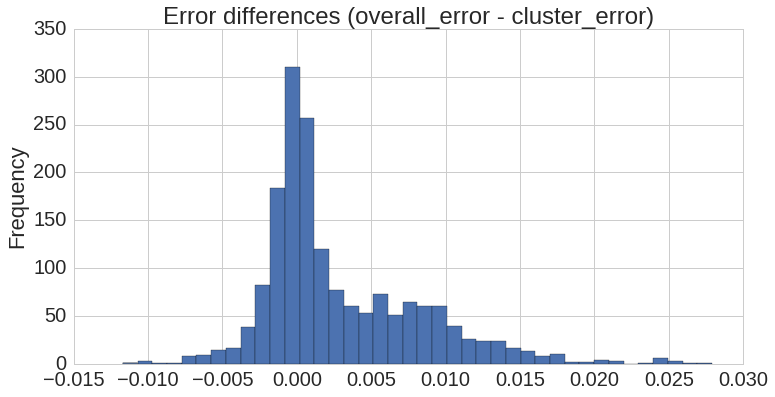

In [14]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(diff_errors, bins = 40)
plt.title('Error differences (overall_error - cluster_error)')
plt.ylabel('Frequency')
# plt.xlim(0.01,0.07)
plt.show()

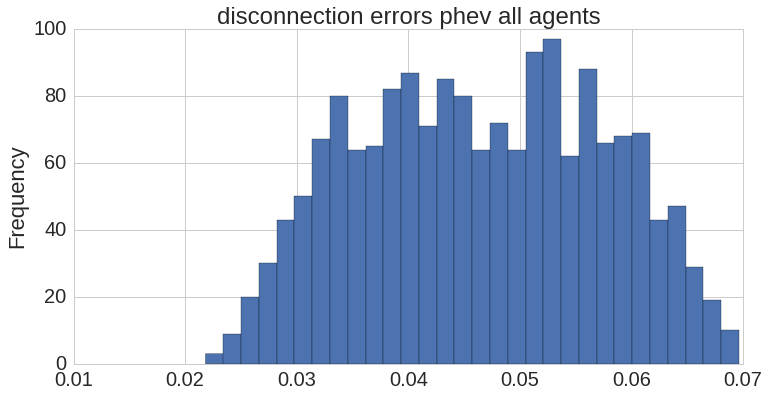

In [135]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(errors_from_mean_overall, bins = 30)
plt.title('disconnection errors phev all agents')
plt.ylabel('Frequency')
plt.xlim(0.01,0.07)
plt.show()

## Connection

In [171]:
con_dists_phev = {}
max_size = 360
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'phev':
        continue
    dists = [list(sum_distributions(data_agents[ID]['connection_duration_dists'][center])) 
                                       for center in data_agents[ID]['connection_duration_dists']]
    
    for i in range(len(dists)):
        while (len(dists[i]) < max_size):
            dists[i].append(0.0)
        dists[i] = dists[i][:max_size]
    dist = sum_lists(dists)
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    con_dists_phev[ID] = dist

In [172]:
max_size = 360
col_names = ['%.2f' %(i *20/60*24) for i in range(max_size)]
clustering_data = []
agent_IDs = []
for ID in con_dists_phev:
    dist = list(con_dists_phev[ID])
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    clustering_data.append(dist)
    agent_IDs.append(ID)
clustering_data = pandas.DataFrame(clustering_data, columns = col_names, index = agent_IDs)

In [182]:
matrix = clustering_data.as_matrix()
birch = sklearn.cluster.Birch(
    threshold = 0.21,
    n_clusters = None,
    branching_factor = 50)
birch.fit(matrix)
results_high_fev = pandas.DataFrame(data = birch.labels_,
    columns=['cluster'], index = clustering_data.index)
# clusters = {tuple(cluster[1].index) for cluster in results.groupby('cluster')}

clusters = results_high_fev['cluster'].unique()
nr_clusters = (len(clusters))
nr_agents = ([len(results_high_fev.loc[results_high_fev['cluster'] == c]) for c in clusters])
print("th (%.2f), bf (%d), %d clusters, %s agents" %(th, bf, nr_clusters, nr_agents))

th (1.99), bf (20000), 7 clusters, [1381, 317, 17, 1, 6, 4, 1] agents


In [ ]:
clusters = results['cluster'].unique()
clusters_errors = {}
for c in clusters:
    agents = list(results.loc[results['cluster'] == c].index)
    mean_dist = plot_mean_dist(agents, dc_dists_phev, c, xmax = 5)
    cluster_errors = {ID: get_error(mean_dist[:max_size], dc_dists_phev_same_length[ID]) for ID in agents}
    errors_from_mean = list(cluster_errors.values())
    clusters_errors.update(cluster_errors)
    seaborn.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(12, 6))
    plt.hist(errors_from_mean, bins = 30)
    plt.title('Errors from mean.\ncluster %s (%d agents)' %(c, len(agents)))
    plt.ylabel('Frequency')
#     plt.xlim(0.01,0.07)
    plt.show()




In [130]:
directory = 'data/simulation_pkls/'
with open(directory + 'connection_distribution_phev.pkl', 'rb') as f:
    connection_distribution_phev = pickle.load(f)
all_agents_normed_phev_con = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'phev':
        continue
    dists = [list(sum_distributions(data_agents[ID]['connection_duration_dists'][center])) 
                                       for center in data_agents[ID]['connection_duration_dists']]
    for i in range(len(dists)):
        while (len(dists[i]) < max_size):
            dists[i].append(0.0)
        dists[i] = dists[i][:max_size]
    dist = sum_lists(dists)
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_phev_con[ID] = dist
agents = list(all_agents_normed_phev_con.keys())
con_errors_from_mean_overall_phev = [get_error(connection_distribution_phev[:max_size], all_agents_normed_phev_con[ID]) 
                            for ID in agents]

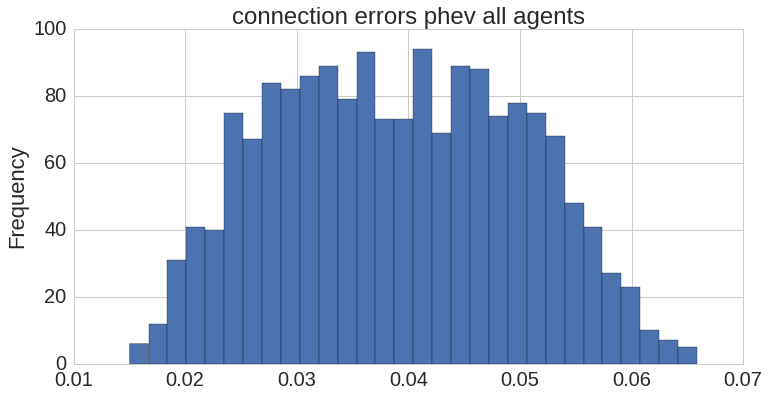

In [136]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(con_errors_from_mean_overall_phev, bins = 30)
plt.title('connection errors phev all agents')
plt.ylabel('Frequency')
plt.xlim(0.01,0.07)
plt.show()

# High FEV

## Disconnection

In [18]:
dc_dists_high_fev = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] == 'fev_high':
        dc_dists_high_fev[ID] = sum_distributions(data_agents[ID]['disconnection_duration_dists'])


In [20]:
max_size = 2880
dc_dists_high_fev_same_length = {}
for ID in dc_dists_high_fev:
    dist = list(dc_dists_high_fev[ID])
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    dc_dists_high_fev_same_length[ID] = dist

Clustering high fev

In [21]:
col_names = ['%.2f' %(i *20/60*24) for i in range(max_size)]
clustering_data = []
agent_IDs = []
for ID in dc_dists_high_fev:
    dist = list(dc_dists_high_fev[ID])
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    clustering_data.append(dist)
    agent_IDs.append(ID)
clustering_data = pandas.DataFrame(clustering_data, columns = col_names, index = agent_IDs)

In [77]:
for th in numpy.arange(0.01, 2.0, 0.01):
    for bf in [2*(10**i) for i in numpy.arange(0, 5)]:
        matrix = clustering_data.as_matrix()
        birch = sklearn.cluster.Birch(
            threshold = th,
            n_clusters = None,
            branching_factor = bf)
        birch.fit(matrix)
        results_high_fev = pandas.DataFrame(data = birch.labels_,
            columns=['cluster'], index = clustering_data.index)
        # clusters = {tuple(cluster[1].index) for cluster in results.groupby('cluster')}

        clusters = results_high_fev['cluster'].unique()
        nr_clusters = (len(clusters))
        nr_agents = ([len(results_high_fev.loc[results_high_fev['cluster'] == c]) for c in clusters])
        print("th (%.2f), bf (%d), %d clusters, %s agents" %(th, bf, nr_clusters, nr_agents))

th (0.01), bf (2), 199 clusters, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] agents
th (0.01), bf (20), 199 clusters, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [84]:
matrix = clustering_data.as_matrix()
birch = sklearn.cluster.Birch(
    threshold = 0.12,
    n_clusters = 7,
    branching_factor = 50)
birch.fit(matrix)
results_high_fev = pandas.DataFrame(data = birch.labels_,
    columns=['cluster'], index = clustering_data.index)
# clusters = {tuple(cluster[1].index) for cluster in results.groupby('cluster')}

clusters = results_high_fev['cluster'].unique()
nr_clusters = (len(clusters))
nr_agents = ([len(results_high_fev.loc[results_high_fev['cluster'] == c]) for c in clusters])
print("th (%.2f), bf (%d), %d clusters, %s agents" %(th, bf, nr_clusters, nr_agents))

th (1.99), bf (20000), 7 clusters, [191, 1, 3, 1, 1, 1, 1] agents


In [67]:
clusters = results_high_fev['cluster'].unique()
print(len(clusters))
print([len(results_high_fev.loc[results_high_fev['cluster'] == c]) for c in clusters])

5
[187, 1, 9, 1, 1]


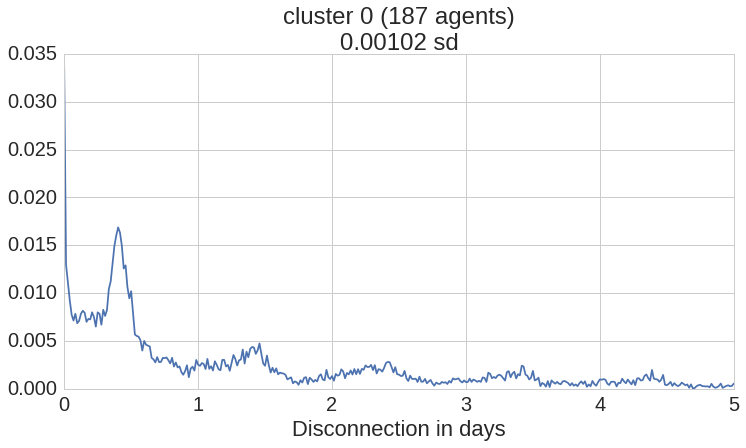

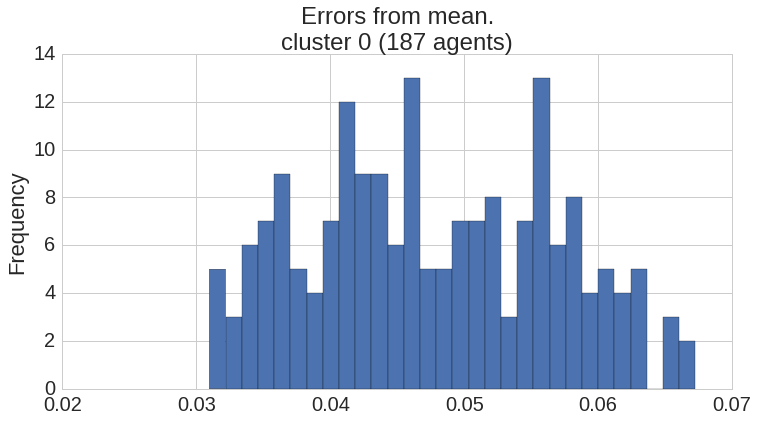

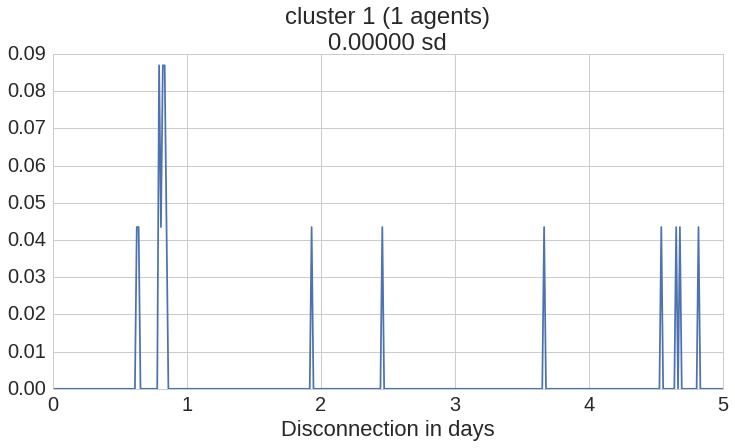

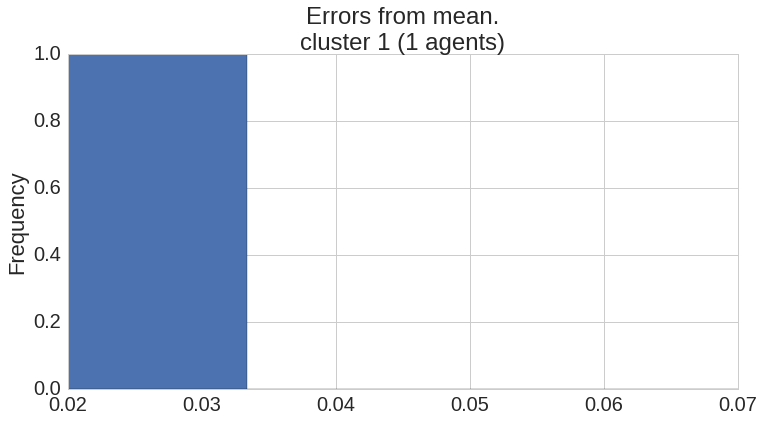

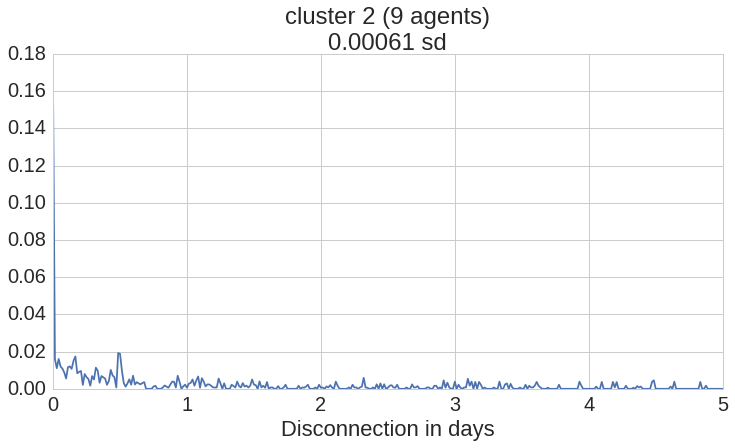

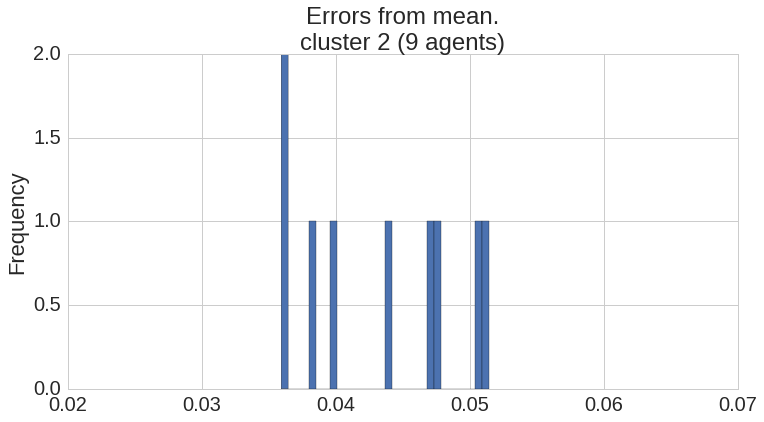

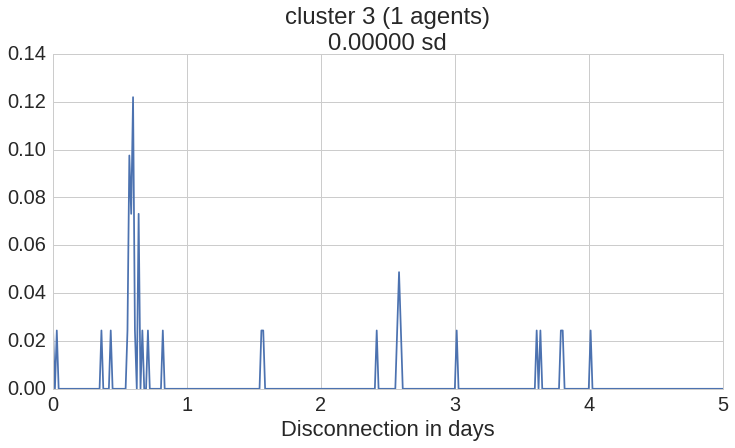

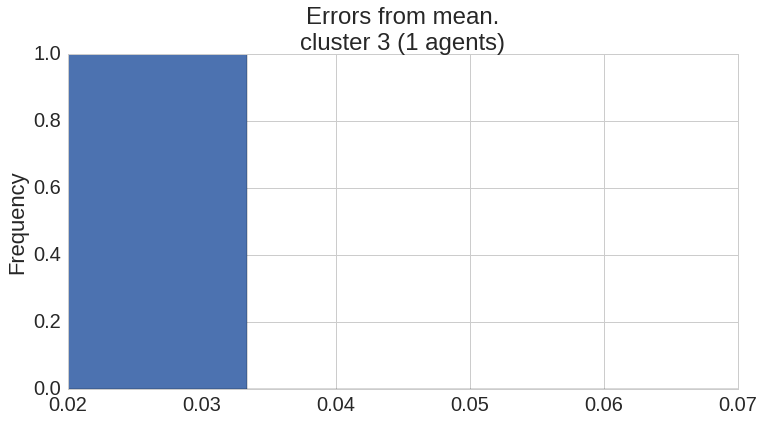

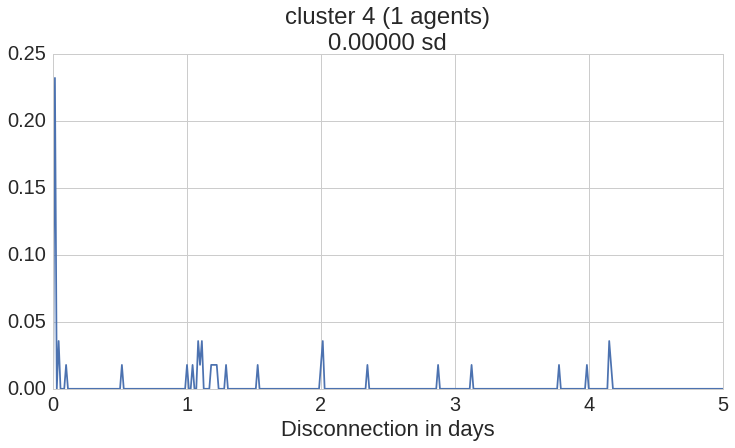

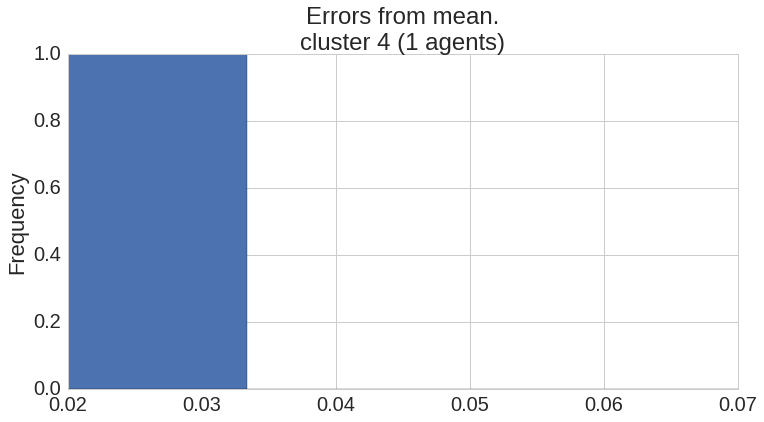

In [61]:
clusters_high_fev = results_high_fev['cluster'].unique()
clusters_errors_high_fev = {}
for c in clusters_high_fev:
    agents = list(results_high_fev.loc[results_high_fev['cluster'] == c].index)
    mean_dist = plot_mean_dist(agents, dc_dists_high_fev, c, xmax = 5)
    cluster_errors = {ID: get_error(mean_dist[:max_size], dc_dists_high_fev_same_length[ID]) for ID in agents}
    errors_from_mean = list(cluster_errors.values())
    clusters_errors_high_fev.update(cluster_errors)
    seaborn.set(style='whitegrid', font_scale=2)
    fig = plt.figure(figsize=(12, 6))
    plt.hist(errors_from_mean, bins = 30)
    plt.title('Errors from mean.\ncluster %s (%d agents)' %(c, len(agents)))
    plt.ylabel('Frequency')
    plt.xlim(0.02,0.07)
    plt.show()


In [114]:
directory = 'data/simulation_pkls/'
max_size = 2880
with open(directory + 'disconnection_distribution_high_fev.pkl', 'rb') as f:
    disconnection_distribution_high_fev = pickle.load(f)
all_agents_normed_dc = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'fev_high':
        continue
    dist = list(sum_distributions(data_agents[ID]['disconnection_duration_dists']))
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_dc[ID] = dist
agents = list(all_agents_normed_dc.keys())
errors_from_mean_overall_high_fev = [get_error(disconnection_distribution_high_fev[:max_size], 
    all_agents_normed_dc[ID]) for ID in agents]

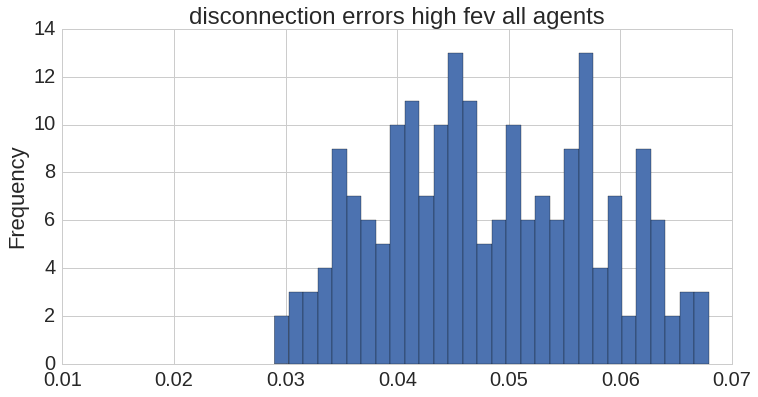

In [137]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(errors_from_mean_overall_high_fev, bins = 30)
plt.title('disconnection errors high fev all agents')
plt.ylabel('Frequency')
plt.xlim(0.01,0.07)
plt.show()

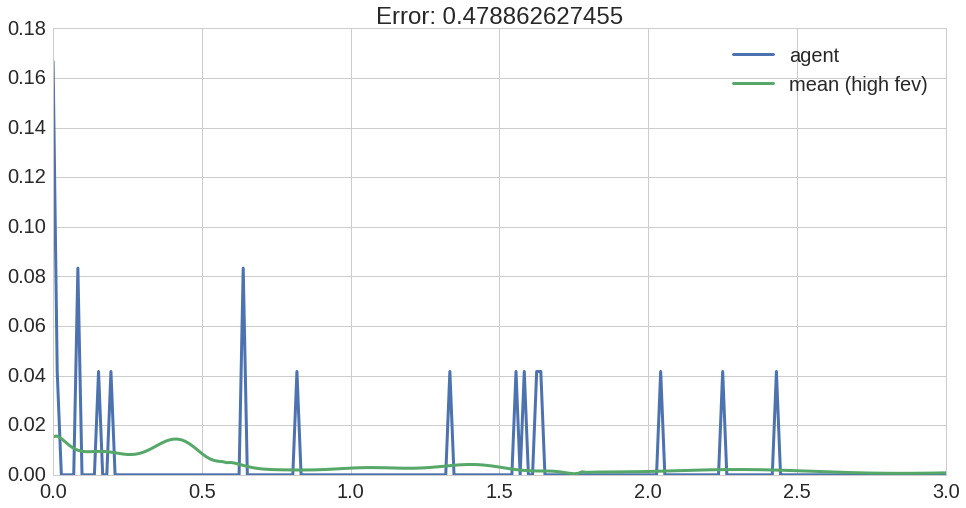

0 0 200


In [183]:
all_agents_normed_dc = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'fev_high':
        continue
    dist = list(sum_distributions(data_agents[ID]['disconnection_duration_dists']))
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_dc[ID] = dist
agents = list(all_agents_normed_dc.keys())

e1 = 0
e2 = 0 
e3 = 0
# print(len(agents))
for i, ID in enumerate(agents):
    error = get_error(disconnection_distribution_high_fev[:max_size], all_agents_normed_dc[ID])
    if error < 0.04:
        e1 +=1
        if e1 > 5:
            continue
    elif error < 0.05:
        e2 += 1
        if e2 > 1:
            continue
    else:
        e3 +=1
        if e3 > 1:
            continue
        else:
            e3 += 1
    xvals = [(1.0 * i *20/60/24) for i in range(max_size)]
    yvals = [all_agents_normed_dc[ID][:2880], disconnection_distribution_high_fev[:max_size]]
    if (len(yvals[0]) != len(yvals[1]) or len(xvals) != len(yvals[0])):
        continue
    ylabs = ['agent', 'mean (high fev)']
    simple_plot_mult_dist(xvals, yvals, ylabs, title = ('Error: ' + str(error)), xmax = 3)
print(e1, e2, e3)

## Connection

In [128]:
directory = 'data/simulation_pkls/'
with open(directory + 'connection_distribution_high_fev.pkl', 'rb') as f:
    connection_distribution_high_fev = pickle.load(f)
all_agents_normed_high_fev_con = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'fev_high':
        continue
    dists = [list(sum_distributions(data_agents[ID]['connection_duration_dists'][center])) 
                                       for center in data_agents[ID]['connection_duration_dists']]
    for i in range(len(dists)):
        while (len(dists[i]) < max_size):
            dists[i].append(0.0)
        dists[i] = dists[i][:max_size]
    dist = sum_lists(dists)
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_high_fev_con[ID] = dist
agents = list(all_agents_normed_high_fev_con.keys())
con_errors_from_mean_overall_high_fev = [get_error(connection_distribution_high_fev[:max_size], 
                                               all_agents_normed_high_fev_con[ID]) 
                            for ID in agents]

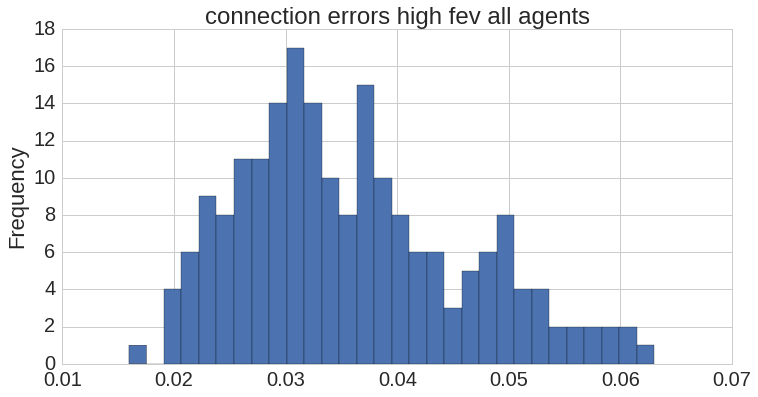

In [138]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(con_errors_from_mean_overall_high_fev, bins = 30)
plt.title('connection errors high fev all agents')
plt.ylabel('Frequency')
plt.xlim(0.01,0.07)
plt.show()

# Low FEV

## Disconnection

In [112]:
directory = 'data/simulation_pkls/'
max_size = 2880
with open(directory + 'disconnection_distribution_low_fev.pkl', 'rb') as f:
    disconnection_distribution_low_fev = pickle.load(f)
all_agents_normed_dc = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'fev_low':
        continue
    dist = list(sum_distributions(data_agents[ID]['disconnection_duration_dists']))
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_dc[ID] = dist
agents = list(all_agents_normed_dc.keys())
errors_from_mean_overall_low_fev = [get_error(disconnection_distribution_low_fev[:max_size], 
    all_agents_normed_dc[ID]) for ID in agents]

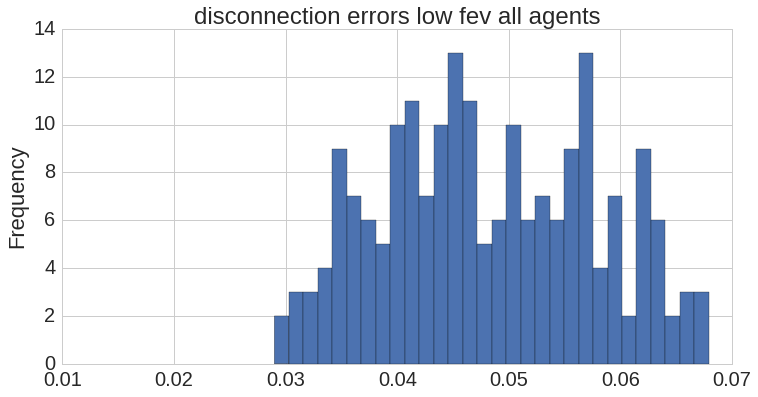

In [139]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(errors_from_mean_overall_high_fev, bins = 30)
plt.title('disconnection errors low fev all agents')
plt.ylabel('Frequency')
plt.xlim(0.01,0.07)
plt.show()

## Connection

In [132]:
directory = 'data/simulation_pkls/'
with open(directory + 'connection_distribution_low_fev.pkl', 'rb') as f:
    connection_distribution_low_fev = pickle.load(f)
all_agents_normed_low_fev_con = {}
for ID in data_agents:
    if data_agents[ID]['battery_category'] != 'fev_low':
        continue
    dists = [list(sum_distributions(data_agents[ID]['connection_duration_dists'][center])) 
                                       for center in data_agents[ID]['connection_duration_dists']]
    for i in range(len(dists)):
        while (len(dists[i]) < max_size):
            dists[i].append(0.0)
        dists[i] = dists[i][:max_size]
    dist = sum_lists(dists)
    while (len(dist) < max_size):
        dist.append(0.0)
    s = sum(dist[:max_size])
    dist = [val / s for val in dist[:max_size]]
    all_agents_normed_low_fev_con[ID] = dist
agents = list(all_agents_normed_low_fev_con.keys())
con_errors_from_mean_overall_low_fev = [get_error(connection_distribution_low_fev[:max_size], 
                                               all_agents_normed_low_fev_con[ID]) 
                            for ID in agents]

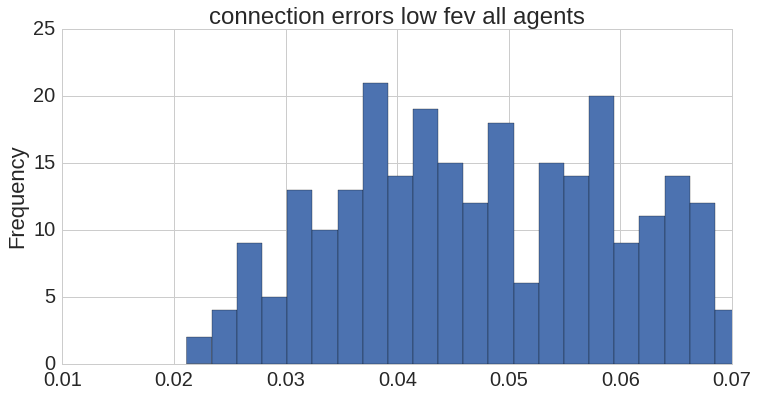

In [140]:
seaborn.set(style='whitegrid', font_scale=2)
fig = plt.figure(figsize=(12, 6))
plt.hist(con_errors_from_mean_overall_low_fev, bins = 30)
plt.title('connection errors low fev all agents')
plt.ylabel('Frequency')
plt.xlim(0.01,0.07)
plt.show()